# Prelab 9.2 Classifying Air-tight Vacuum and Air-leak Vacuum Data using Autoencoders for Anomaly Detection

In this example, you will use an machine learning algorithm called autoencoder  to detect anomalies on a vacuum pump. An accelerometer was used to collect data in all three dimensions (x, y, z). This dataset contains 1,200 rows of one second, each with 1000 data points. From the total number of rows, 600 (seconds) rows are labeled from vacuuming and 600 (seconds) of air leakage. 

<img src="https://github.com/hewp84/tinyml/blob/main/img/slide1.png?raw=1" width="531" height="300"/>

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? An autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal vibrations only, then use it to reconstruct all the data. Our hypothesis is that the abnormal vibrations will have higher reconstruction error. You will then classify a vibration as an anomaly if the reconstruction error surpasses a fixed threshold.

Note: This Colab is adapted from the tensorflow [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) example.

##Working in the X-dimension

### Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.fftpack
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

### Load Vacuum data

The dataset to be used was pulled from a csv filed saved in a github repository [Prelab9 vacuum data](https://github.com/hewp84/tinyml/blob/439f321e572a55cf0b4ee5f358f6820ff8f98cbf/datasets/Prelab9_data.csv).

In [ ]:
# Copying raw data from github dataset file
url = 'https://raw.githubusercontent.com/hewp84/tinyml/main/datasets/Prelab9_data.csv'
#df is the variable where the data is stored
df = pd.read_csv(url)
#Display the original content of the dataset
df

###Data Transformation

The strategy to build this model is to select, one by one, data from each dimension and assess which dimension helps the model classify with better accuracy and precision.

Let's start with the X dimension:

Assign the X dimension on the variable DIMENSION on the code below.

In [ ]:
# X-dimension: 'Xacc array [m/s2]'
# Y-dimension: 'Yacc array [m/s2]'
# Z-dimension: 'Zacc array [m/s2]'
DIMENSION =  #Type the X-dimension column name to use data from this dimension to build a model    <-----------------------------------------------------------------------------

#Exploding the values contained in selected column and converting the string values into float values
df = pd.concat([df['Condition'],df[DIMENSION].str.split(' ', expand=True).astype(float)], axis=1)
ds = df.copy()

Now, we change the labels 'Vacuuming' and 'Air_leakage' into binary notation for the model usage.

In [ ]:
#Converting the Classifier into binary values
ds.loc[df['Condition'] == 'Vacuuming', 'Status'] = 1
ds.loc[df['Condition'] == 'Air_leakage', 'Status'] = 0
ds.drop('Condition', axis=1, inplace=True)
#Displays the dataset
ds

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Status
0,0.627626,0.078453,-1.725970,3.451941,-3.138128,-2.902768,1.647517,0.000000,-0.627626,-0.706079,...,1.255251,0.862985,-0.941438,-5.570177,-4.550286,-3.844207,-6.903882,0.549172,2.588956,1.0
1,-4.864098,-4.079566,1.569064,4.942552,1.412158,4.001113,6.433162,0.235360,-5.021005,-6.825428,...,1.725970,-3.451941,0.549172,3.687300,0.000000,-4.707192,2.039783,-0.313813,-3.844207,1.0
2,-3.138128,3.765754,0.784532,-0.941438,-2.510502,5.727084,2.510502,-2.275143,0.000000,1.490611,...,3.059675,-3.765754,-6.433162,1.255251,5.334818,-1.019892,-1.333704,2.510502,-0.784532,1.0
3,-2.510502,-5.099458,3.608847,1.255251,-4.393379,-2.039783,1.176798,0.392266,-4.393379,-1.333704,...,-4.785645,-1.255251,0.706079,0.313813,-1.725970,1.255251,4.550286,0.156906,-5.099458,1.0
4,-2.667409,-2.510502,-1.019892,-1.255251,-5.021005,0.000000,4.158020,-0.392266,-3.765754,-1.725970,...,0.784532,-6.433162,0.000000,3.922660,5.962443,-1.255251,0.156906,1.569064,-2.510502,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.000000,0.627626,1.098345,-2.588956,1.176798,-1.255251,5.334818,0.862985,-3.844207,-4.079566,...,2.510502,1.647517,-2.039783,-0.627626,-1.412158,1.882877,-1.412158,0.000000,-2.510502,0.0
1196,-6.903882,-2.667409,-1.804424,-3.608847,3.059675,-5.962443,1.882877,6.433162,0.000000,-2.353596,...,-1.490611,0.000000,0.862985,0.235360,-0.627626,2.588956,1.019892,8.786758,0.000000,0.0
1197,-3.138128,-2.824315,5.491724,0.706079,-2.118236,-10.042010,6.746975,13.101684,-1.490611,-2.510502,...,-5.727084,-4.158020,-5.021005,2.118236,5.021005,-5.727084,-1.255251,2.118236,0.235360,0.0
1198,-0.706079,0.941438,-10.120463,8.159133,-6.040896,-0.627626,-2.510502,-2.432049,-2.588956,-1.176798,...,7.217694,-1.255251,-5.648630,-3.216581,3.922660,0.000000,-1.647517,2.432049,-9.100571,0.0


Now is time to separate the data values from the label values. After that, the data is splitted into training and testing data. A good hereustic number for the test size data is 20% of the dataset. 

In [ ]:
raw_data = ds.values
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the vacuum accelerometer data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Prior to training the autoencoder, we first apply a minmax scaling transform to the input data which converts it from its original range to a range of (0 to 1) This is done for two main reasons. First, existing research suggests that neural networks in general train better when input values lie between 0 and 1 (or have zero mean and unit variance). Secondly, scaling the data supports the learning objective for the autoencoder (minimizing reconstruction error) and makes the results more interpretable. 

In general, the range of output values from the autoencoder is dependent on the type of activation function used in the output layer. For example, the tanh activation function outputs values in the range of -1 and 1, sigmoid outputs values in the range of 0 - 1. In the example, we use the sigmoid activation function in the output layer of the autoencoder, allowing us directly compare the transformed input signal to the output data when computing the means square error metric during training. In addition, having both input and output in the same range allows us to visualize the differences that contribute to the anomaly classification.

In [ ]:
#Normalizing the values of the dataset 
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal vibrations from the abnormal vibrations.

In [ ]:
#Splitting the dataset based on classification: train_labels: Vacuuming, ~train_labels: Air Leakage
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

portion_of_anomaly_in_training = 0.1 #10% of training data will be anomalies
end_size = int(len(normal_train_data)/(10-portion_of_anomaly_in_training*10))
combined_train_data = np.append(normal_train_data, anomalous_test_data[:end_size], axis=0)
combined_train_data.shape

(536, 1000)

Plot a normal vibration signal

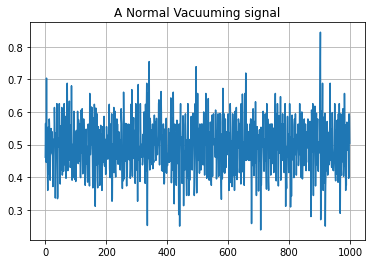

In [ ]:
#Plotting sample of normal data
plt.grid()
plt.plot(np.arange(1000), normal_train_data[0])
plt.title("A Normal vibration signal")
plt.show()

Plot an anomalous vibration signal

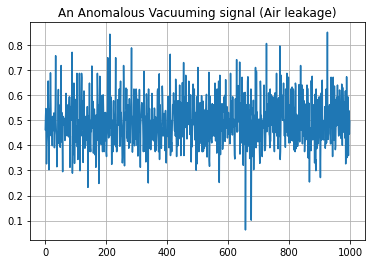

In [ ]:
#Plotting sample of anomalous data
plt.grid()
plt.plot(np.arange(1000), anomalous_train_data[0])
plt.title("An abnormal vibration signal (Air leakage)")
plt.show()

In [ ]:
#@title Q1. What What differences do you notice between the normal and anomalous plots?

Q1 = '' #@param {type:"string"}

print(Q1)

### Picking an Embedding to Build the Model

After training and evaluating the example model, try modifying the size and number of layers to build an understanding for autoencoder architectures.

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. Feel free to play around with that layer size by assigning a value to the variable EMBEDDING_SIZE.

In [ ]:
#Creating the artificial neural network using Autoencoder
EMBEDDING_SIZE =  #Define how many neurons in the inner layer   <-----------------------------------------------------------------------------
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(EMBEDDING_SIZE, activation="relu")]) # Smallest Layer Defined Here
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(1000, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
print("Chosen Embedding Size: ", EMBEDDING_SIZE)
autoencoder.compile(optimizer='adam', loss='mae')

Chosen Embedding Size:  12


### Train the model

Notice that the autoencoder is trained using only the normal vibrations, but is evaluated using the full test set.

In [ ]:
#Training the model. 
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=200, 
          batch_size=200,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/200
3/3 [==============================] - 1s 107ms/step - loss: 0.0618 - val_loss: 0.0656
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0615 - val_loss: 0.0655
Epoch 3/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0615 - val_loss: 0.0655
Epoch 4/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0615 - val_loss: 0.0655
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 6/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 7/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 8/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 10/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0615 - val_loss: 0.0656
Epoch 11/200
3/3 [

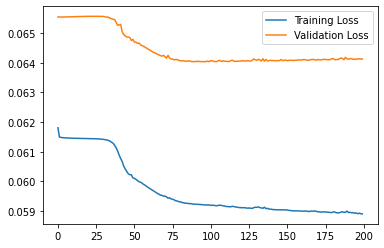

In [ ]:
#Plotting the evolution of training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean absolute error_. There is a distinct loss value given for the training and the validation data. As a rule of thumb for this metric, 10% or less is an acceptable value for loss function. If it is not, you might want to refine the inner layer or the epochs.


Try varying the inner layer  to different values between 1 and 16 and see how the loss function changes due to the changes.

In [ ]:
#@title Q2. What happen to the loss function graphs as you vary the neurons in the inner layer (Embedding size)?

Q2 = '' #@param {type:"string"}

print(Q2)

### ROC and AUC Metrics

The Receiver Operating Characteristic (ROC) plots allows us to visualize the tradeoff between predicting anomalies as normal (false positives) and predicting normal data as an anomaly (false negative). Normal vibrations are labeled as `1` in this dataset but we have to flip them here to match the ROC curves expectations.

The ROC plot now has threshold values plotted on their corresponding points on the curve to aid in selecting a theshold for the application.

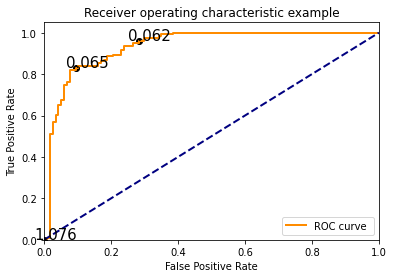

In [ ]:
#Plotting True positive and false positive rate assessment
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
fpr = []
tpr = []
#the test labels are flipped to match how the roc_curve function expects them.
flipped_labels = 1-test_labels 
fpr, tpr, thresholds = roc_curve(flipped_labels, loss)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# plot some thresholds
thresholds_every=20
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
  threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
  plt.scatter(fpr[i], tpr[i], c='black')
  plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15});

plt.show()


To pick the threshold that would give us the high true positive rate (TPR) and low false positive rate (FPR) we look at the 'knee' of the curve.

However, in some cases there may be an application constraint that requires a specific TPR or FPR, in which case we would have to move off of the 'knee' and sacrifice overall accuracy. In this case we might rather have false alarms than miss an abnormal vibration.

Now that we understand how to visualize the impact of the selected threshold, we calculate the area under the ROC curve (AUC). 

This metric is very useful for evalutation of a specfic model design. Adjust the size of the encoding layer (EMBEDDING SIZE) in the autoencoder to maximize this metric.

In [ ]:

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9473281912306303


In [ ]:
#@title Q3. How does the ROC changes as you vary the neurons in the inner layer (Embedding size)?

Q3 = '' #@param {type:"string"}

print(Q3)

### Picking a Threshold to Detect Anomalies
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

Try to maximize the accuracy, precision, and recall. Think about the application and the consequences of a false positive and a false negative. 

Experiment by using different values (values labeled in black in the ROC graph) as a threshold below

[More details on precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [ ]:
threshold =  #Assign a value labeled in black in the ROC graph  <-----------------------------------------------------------------------------
print("Chosen Threshold: ", threshold)

SyntaxError: ignored

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8416666666666667
Precision = 0.9438202247191011
Recall = 0.717948717948718


For most anomaly detection problems, accuracy is not enough to assess the power of detection of the model. Accuracy alone does not tell the complete story i.e. how often does the model flag an vibration as abnormal when it is indeed abnormal (true positive), abnormal when it is normal (false positive) normal when it is abnormal (false negative) and normal when it is indeed normal (true negative). Two important metrics can be applied to address these issues - precision aand recall. 

Precision expresses the percentage of positive predictions that are correct and is calculated as (true positive / true positive + false positive ). 

Recall expresses the proportion of actual positives that were corrected predicted (true positive / true positive + false negative).

Depending on the use case, it may be desirable to optimize a model's performance for high precision or high recall. This tradeoff between precision and recall can be adjusted by the selection of a threshold (e.g. a low enough threshold will yield excellent recall but reduced precision). In addition, the Receiver Operating Characteristics (ROC) curve provides a visual assessment of a model's skill (area under the curve - AUC) and is achieved by plotting the true positive rate against the false positive rate at various values of the threshold. 

In [ ]:
#@title Q4. Which threshold value provides the best metrics to refine the classification model? Explain why.

Q4 = '' #@param {type:"string"}

print(Q4)


Please continue to [Prelab 9.3 here](PL9_Colab3.ipynb).
